Preparation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann
import random
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import mode

In [2]:
import data_corruption

In [3]:
def spect_noise_estimation(spect, qntty, ppm):
  std_array = np.empty(qntty)

  for i in range(qntty):
    idx_noise_1 = np.abs(ppm[i,:] - 8.5).argmin()
    idx_noise_2 = np.abs(ppm[i,:] - 9.5).argmin()
    idx_noise_3 = np.abs(ppm[i,:] - 10.5).argmin()

    #assumes ppm is inverted: smaller values in higher indexes
    ppm_array_1 = ppm[i,idx_noise_2:idx_noise_1]
    ppm_array_2 = ppm[i,idx_noise_3:idx_noise_2]
    spect_array_1 = np.real(spect[i,idx_noise_2:idx_noise_1])
    spect_array_2 = np.real(spect[i,idx_noise_3:idx_noise_2])

    estimate_1 = np.polyfit(ppm_array_1, spect_array_1, 2)
    estimate_2 = np.polyfit(ppm_array_2, spect_array_2, 2)
    aux_1 = (estimate_1[0]*(ppm_array_1**2)) + (estimate_1[1]*ppm_array_1) +  estimate_1[2]
    aux_2 = (estimate_2[0]*(ppm_array_2**2)) + (estimate_2[1]*ppm_array_2) +  estimate_2[2]
    detrending_1 = spect_array_1 - aux_1
    detrending_2 = spect_array_2 - aux_2
    std_1 = np.std(detrending_1)
    std_2 = np.std(detrending_2)

    if np.abs(std_1) < np.abs(std_2):
      std = std_1
    else:
      std = std_2

    std_array[i] = std

  return std_array

def spect_SNR_estimation(spect, qntty, ppm, ppm_min_peak,ppm_max_peak):

  noise_array = spect_noise_estimation(spect, qntty, ppm)
  SNR_array = np.empty(qntty)
  peak_array = np.empty(qntty)

  for i in range(qntty):
    idx_GABA_0 = np.abs(ppm[i,:] - ppm_min_peak).argmin()
    idx_GABA_1 = np.abs(ppm[i,:] - ppm_max_peak).argmin()
    peak_amplitude = np.max(np.abs(np.real(spect[i,idx_GABA_1:idx_GABA_0])))

    SNR = peak_amplitude/(2*noise_array[i])
    SNR_array[i] = SNR
    peak_array[i] = peak_amplitude

  return SNR_array, noise_array, peak_array

In [4]:
def normalize_vector_between_minus_one_and_one(complex_array):
    real_parts = complex_array.real
    imaginary_parts = complex_array.imag

    min_real = np.min(real_parts)
    max_real = np.max(real_parts)
    min_imaginary = np.min(imaginary_parts)
    max_imaginary = np.max(imaginary_parts)

    range_real = max_real - min_real
    range_imaginary = max_imaginary - min_imaginary

    normalized_real = (((real_parts - min_real)/range_real)*2)-1
    normalized_imaginary = (((imaginary_parts - min_imaginary)/range_imaginary)*2)-1

    normalized_complex_array = normalized_real + 1j*normalized_imaginary
    return normalized_complex_array

def get_normalized_spectrogram(fids,qntty,a,b,norm_abs,correct_time):
    w = hann(256, sym=True)
    mfft_ = 446
    SFT = ShortTimeFFT(w, hop=10, fs=bandwidth, mfft=mfft_, scale_to='magnitude', fft_mode = 'centered')
    t_lo, t_hi, f_lo, f_hi = SFT.extent(fids.shape[1])
    spgram = []
    for i in range(qntty):
        aux = SFT.stft(fids[i,:])
        if norm_abs == True:
            spgram.append(aux/np.max(np.abs(aux)))
        else:
            spgram.append(normalize_vector_between_minus_one_and_one(aux))
    spgram = np.array(spgram)
    
    freq_spect = np.flip(np.linspace(f_lo,f_hi,mfft_))
    ppm_spect = a*freq_spect+b
    t_spect = np.linspace(t_lo,t_hi,spgram.shape[2])

    if correct_time == True:
        zero_idx = np.abs(t_spect - 0.0).argmin()
        one_idx = np.abs(t_spect - 1.0).argmin()
        t_spect = t_spect[zero_idx:one_idx]
        spgram = spgram[:,:,zero_idx:one_idx]
    
    return spgram, freq_spect, ppm_spect, t_spect

In [5]:
qntty = 5

In [6]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(5, 2048, 2)
(5, 2048)
(5, 2048)


In [7]:
### to create corrupted dataset

tm = data_corruption.TransientMaker(gt_fids,t,transients=160)
tm.add_random_amplitude_noise(6,2)
corrupted_fids = tm.fids

In [8]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

In [9]:
#get spectrum (using ifft will cause the spectrum to have a phase inverted with respect to the actual phase of the fft of the fid)
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_corrupted_fids = np.fft.fftshift(np.fft.ifft(corrupted_fids,n=N,axis = 1), axes = 1)
#diff: FT(on) - FT(off)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
#diff: FT(on_i) - FT(off_i)
spectra_corrupted_diff = spectra_corrupted_fids[:,:,1,:] - spectra_corrupted_fids[:,:,0,:]
#frequency axis in Hz fliped to match ppm descending character
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

In [10]:
spectra_corrupted_diff_avgs = np.mean(spectra_corrupted_diff, axis = 2)

In [11]:
#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]
#ppm_aux = b + freq*a
print(a)
print(b)

0.007828953034110766
3.0038227309736873


In [12]:
#plot index
idx = 0

(4.0, 2.5)

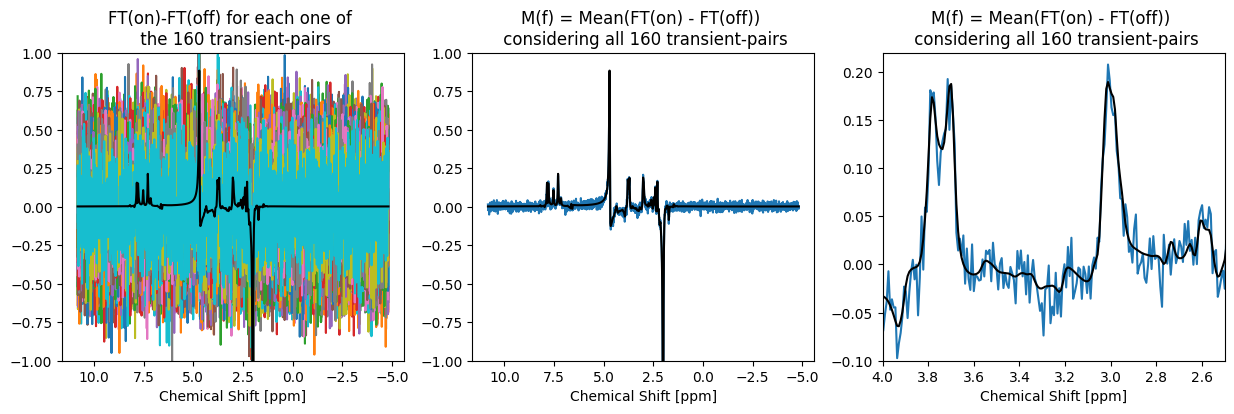

In [13]:
fig,ax = plt.subplots(1,3 ,figsize=(15,4))
for i in range(160):
  ax.flat[0].plot(ppm[idx,:],np.real(spectra_corrupted_diff[idx,:,i]))
ax.flat[0].set_title('FT(on)-FT(off) for each one of \n the 160 transient-pairs')

ax.flat[1].plot(ppm[idx,:],np.real(spectra_corrupted_diff_avgs[idx,:]))
ax.flat[1].set_title('M(f) = Mean(FT(on) - FT(off)) \n considering all 160 transient-pairs')
ax.flat[2].plot(ppm[idx,:],np.real(spectra_corrupted_diff_avgs[idx,:]))
ax.flat[2].set_title('M(f) = Mean(FT(on) - FT(off)) \n considering all 160 transient-pairs')

for i in range(3):
  ax.flat[i].plot(ppm[idx,:],np.real(spectra_gt_diff[idx,:]), color = 'black')
  ax.flat[i].invert_xaxis()
  ax.flat[i].set_xlabel('Chemical Shift [ppm]')

for i in range(2):
  ax.flat[i].set_ylim(-1,1)

ax.flat[2].set_ylim(-0.1,0.22)
ax.flat[2].set_xlim(4,2.5)

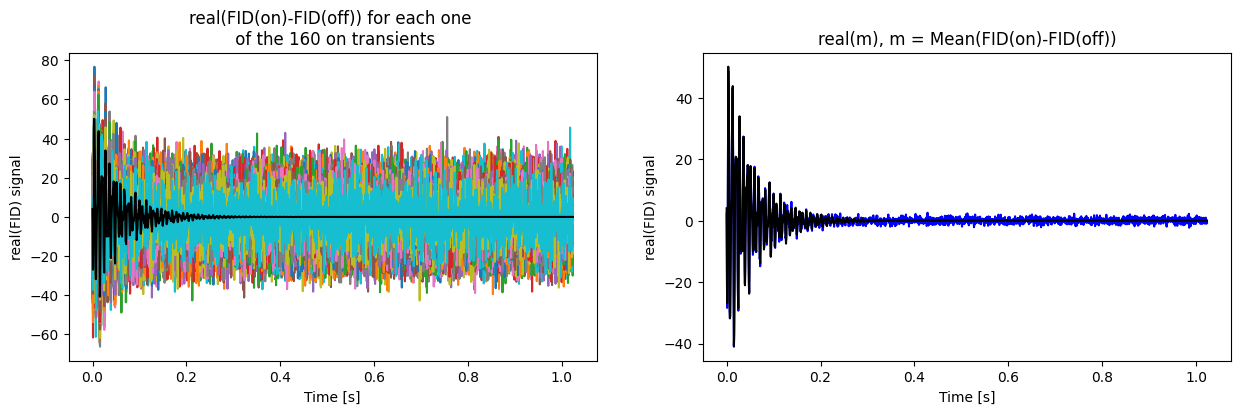

In [14]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
for i in range(160):
  ax.flat[0].plot(t[idx,:],np.real(corrupted_fids[idx,:,1,i]-corrupted_fids[idx,:,0,i]))
ax.flat[0].set_title('real(FID(on)-FID(off)) for each one \n of the 160 on transients')

ax.flat[1].plot(t[idx,:],np.real(np.mean(corrupted_fids[idx,:,1,:]-corrupted_fids[idx,:,0,:], axis = 1)),color = 'blue')
ax.flat[1].set_title('real(m), m = Mean(FID(on)-FID(off))')

for i in range(2):
  ax.flat[i].plot(t[idx,:],np.real(gt_fids[idx,:,1]-gt_fids[idx,:,0]), color = 'black')
  ax.flat[i].set_xlabel('Time [s]')
  ax.flat[i].set_ylabel('real(FID) signal')

In [15]:
SNR_corrupted_avgs, std_corrupted_avgs, peak_corrupted_avgs = spect_SNR_estimation(spectra_corrupted_diff_avgs, qntty, ppm, 2.79, 3.55)

In [16]:
spgram_corrupted_avgs_normABS, freq_spect, ppm_spect, t_spect = get_normalized_spectrogram(np.mean((corrupted_fids[:,:,1,:]-corrupted_fids[:,:,0,:]), axis = 2),qntty,a,b,True,True)
spgram_gt_normABS, freq_spect, ppm_spect, t_spect = get_normalized_spectrogram(gt_fids[:,:,1]-gt_fids[:,:,0],qntty,a,b,True,True)

In [17]:
print(freq_spect[0],freq_spect[-1])
print(ppm_spect[0],ppm_spect[-1])

995.5156950672645 -999.9999999999999
10.797668352375435 -4.825130303137078


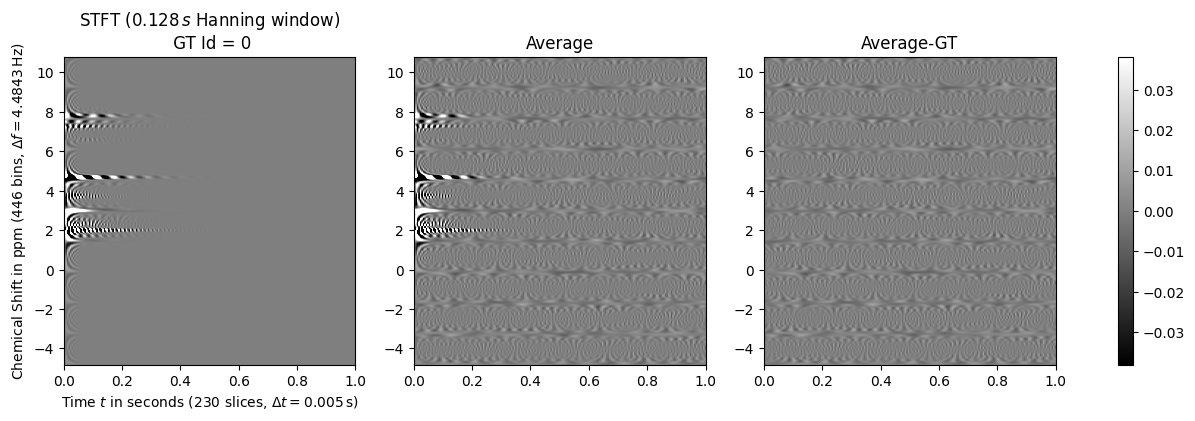

In [18]:
idx = 0

nrows=1
ncols=3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,4*nrows))

w = hann(256, sym=True)
mfft_ = 446
SFT = ShortTimeFFT(w, hop=10, fs=bandwidth, mfft=mfft_, scale_to='magnitude', fft_mode = 'centered')
t_lo, t_hi, f_lo, f_hi = SFT.extent(gt_fids.shape[1])

N_points = gt_fids[0,:,0].shape[0]
#t_lo, t_hi = SFT.extent(N_points)[:2]  # time range of plot
t_lo,t_hi=0,1

idx_plot = []
if nrows == 1:
  idx_plot.append(idx)
for i in range(nrows):
  idx_plot.append(random.randint(0, qntty))

ax.flat[0].set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Hanning window)"+ '\n GT Id = '+str(idx_plot[i]))
ax.flat[0].set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N_points)} slices, " + rf"$\Delta t = {SFT.delta_t:g}\,$s)",
               ylabel=f"Chemical Shift in ppm ({SFT.f_pts} bins, " + rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

vmin_ = np.mean(np.real(spgram_gt_normABS[idx_plot[0],:,:]))-2*np.std(np.real(spgram_gt_normABS[idx_plot[0],:,:]))
vmax_ = np.mean(np.real(spgram_gt_normABS[idx_plot[0],:,:]))+2*np.std(np.real(spgram_gt_normABS[idx_plot[0],:,:]))

#PLOT ONLY REAL PT
for i in range(nrows):
  im = ax.flat[i*ncols].imshow(np.real(spgram_gt_normABS[idx_plot[i],:,:]), origin='lower', aspect='auto',
                 extent=(t_lo,t_hi,ppm_spect[-1],ppm_spect[0]), cmap='gray', vmin=vmin_, vmax = vmax_)
  im = ax.flat[i*ncols+1].imshow(np.real(spgram_corrupted_avgs_normABS[idx_plot[i],:,:]), origin='lower', aspect='auto',
                 extent=(t_lo,t_hi,ppm_spect[-1],ppm_spect[0]), cmap='gray' , vmin=vmin_, vmax = vmax_)
  im = ax.flat[i*ncols+2].imshow(np.real(spgram_corrupted_avgs_normABS[idx_plot[i],:,:])-np.real(spgram_gt_normABS[idx_plot[i],:,:]), origin='lower', aspect='auto',
                 extent=(t_lo,t_hi,ppm_spect[-1],ppm_spect[0]), cmap='gray' , vmin=vmin_, vmax = vmax_)
  if i*ncols != 0:
    ax.flat[i*ncols].set_title(rf"GT Id = "+ str(idx_plot[i]))
  ax.flat[i*ncols+1].set_title('Average')
  ax.flat[i*ncols+2].set_title('Average-GT')
  if nrows == 1:
    fig.colorbar(im, ax=ax.ravel().tolist())
  else:
    fig.colorbar(im, ax=ax[i,:])

(443770,)


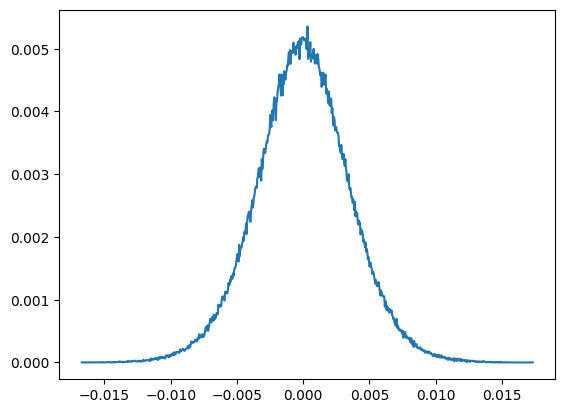

In [19]:
residual = (np.real(spgram_corrupted_avgs_normABS)-np.real(spgram_gt_normABS)).reshape(-1)
print(residual.shape)
aux, bins = np.histogram(residual,800)
plt.plot(bins[:-1],aux/aux.sum())

In [20]:
div = 5
aux_s = int(t_spect.shape[0]/div)
signal_series = np.empty((div,spgram_gt_normABS.shape[0]*spgram_gt_normABS.shape[1]*aux_s))
for i in range(div):
    signal_series[i,:] = (np.real(spgram_corrupted_avgs_normABS[:,:,i*aux_s:aux_s*(i+1)])-np.real(spgram_gt_normABS[:,:,i*aux_s:aux_s*(i+1)])).reshape(-1)

In [21]:
print(signal_series.shape)

(5, 86970)


In [22]:
bins_ = 100
hist_series  = np.empty((div,bins_))
bins_series = np.empty((div,bins_+1))
for i in range(5):
    aux, bins = np.histogram(signal_series[i,:],bins_)
    hist_series[i,:] = aux/aux.sum()
    bins_series[i,:] = bins

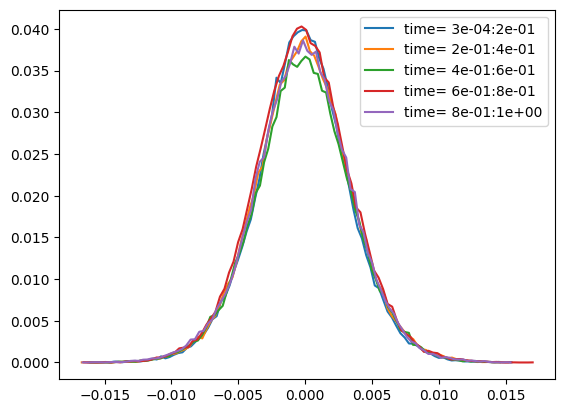

In [23]:
for i in range(div):
    plt.plot(bins_series[i,:-1],hist_series[i,:],label='time= '+f"{t_spect[i*aux_s]:.0e}"+':'+f"{t_spect[(i+1)*aux_s]:.0e}")
plt.legend(loc='upper right')

In [25]:
div = 5
aux_s = int(ppm_spect.shape[0]/div)
signal_series = np.empty((div,spgram_gt_normABS.shape[0]*spgram_gt_normABS.shape[2]*aux_s))
for i in range(div):
    signal_series[i,:] = (np.real(spgram_corrupted_avgs_normABS[:,i*aux_s:aux_s*(i+1),:])-np.real(spgram_gt_normABS[:,i*aux_s:aux_s*(i+1),:])).reshape(-1)

In [26]:
print(signal_series.shape)

(5, 88555)


In [27]:
bins_ = 100
hist_series  = np.empty((div,bins_))
bins_series = np.empty((div,bins_+1))
for i in range(5):
    aux, bins = np.histogram(signal_series[i,:],bins_)
    hist_series[i,:] = aux/aux.sum()
    bins_series[i,:] = bins

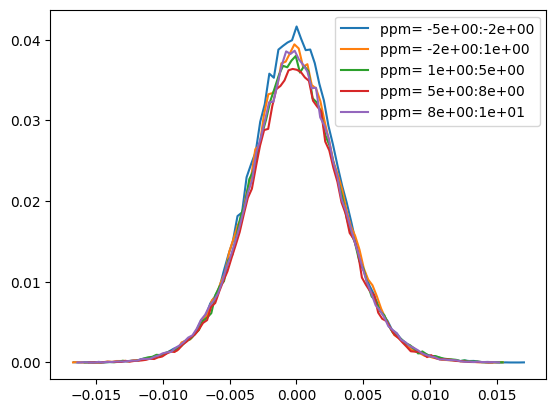

In [29]:
for i in range(div):
    plt.plot(bins_series[i,:-1],hist_series[i,:],label='ppm= '+f"{np.flip(ppm_spect)[i*aux_s]:.0e}"+':'+f"{np.flip(ppm_spect)[(i+1)*aux_s]:.0e}")
plt.legend(loc='upper right')

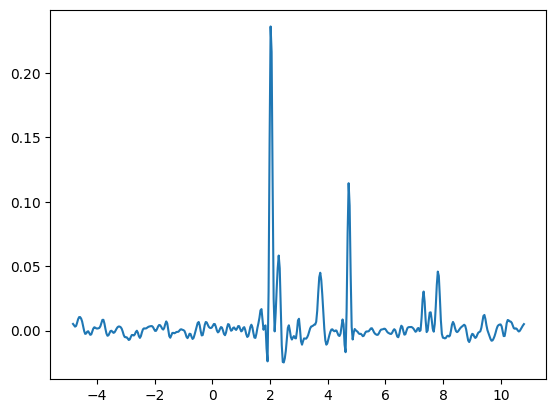

In [34]:
idx_time_1 = np.abs(t_spect - 0.1).argmin()
plt.plot(np.flip(ppm_spect),np.real(spgram_corrupted_avgs_normABS[idx,:,idx_time_1]))
#plt.xlim(-4,-1)
#plt.ylim(-0.02,0.02)

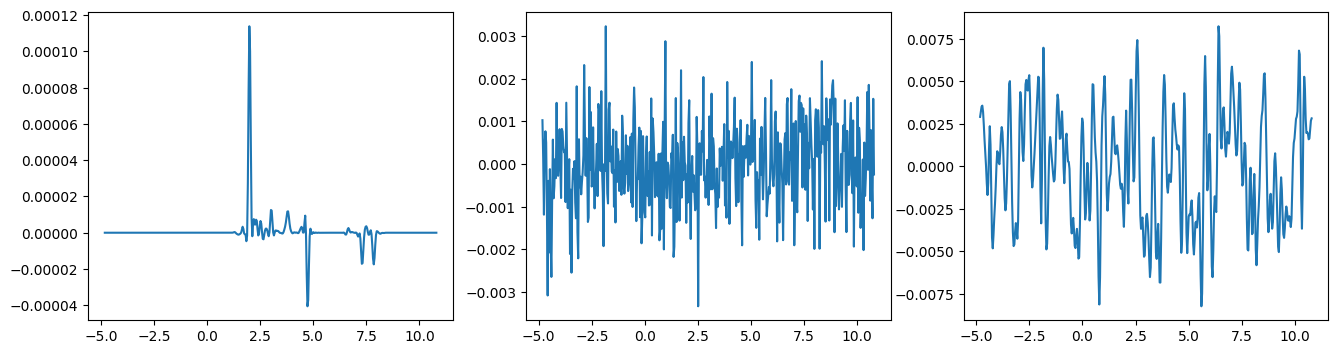

In [36]:
noise_real = np.random.normal(0,0.001,size=spgram_gt_normABS.shape)
noise_added = np.real(spgram_gt_normABS) + noise_real
idx_time_1 = np.abs(t_spect - 0.6).argmin()
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].plot(np.flip(ppm_spect),np.real(spgram_gt_normABS[idx,:,idx_time_1]))
ax[1].plot(np.flip(ppm_spect),np.real(noise_added[idx,:,idx_time_1]))
ax[2].plot(np.flip(ppm_spect),np.real(spgram_corrupted_avgs_normABS[idx,:,idx_time_1]))

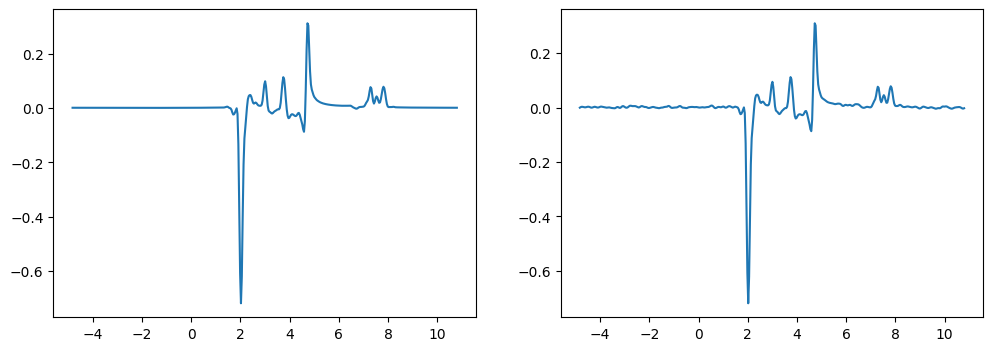

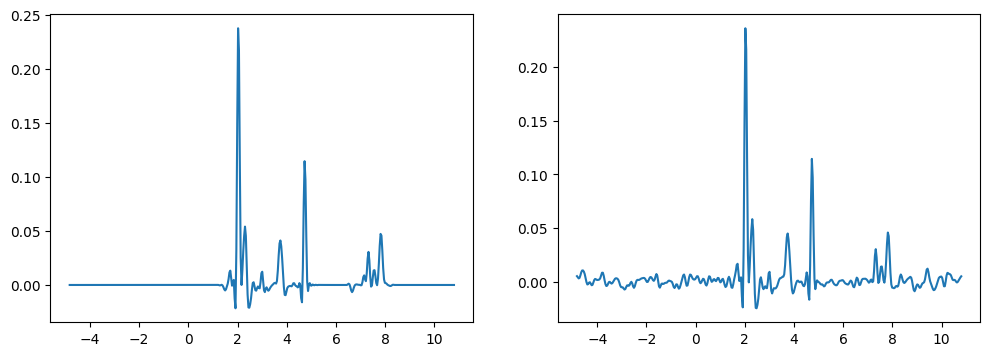

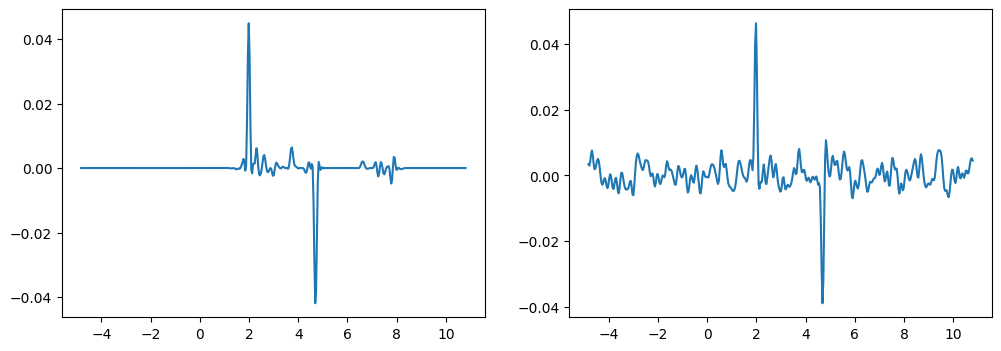

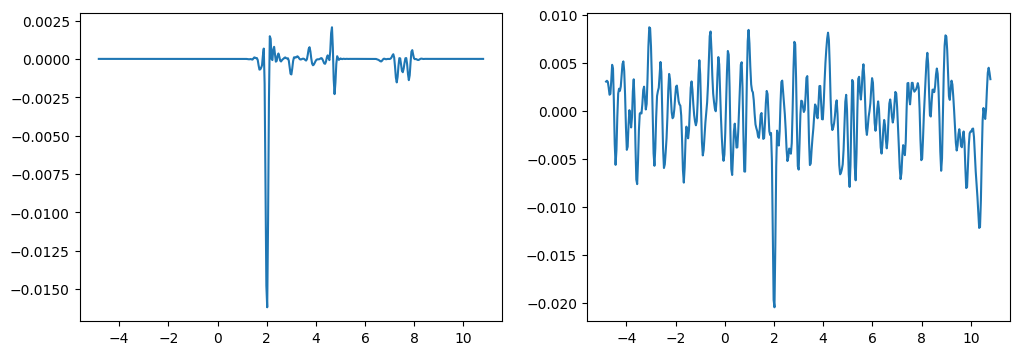

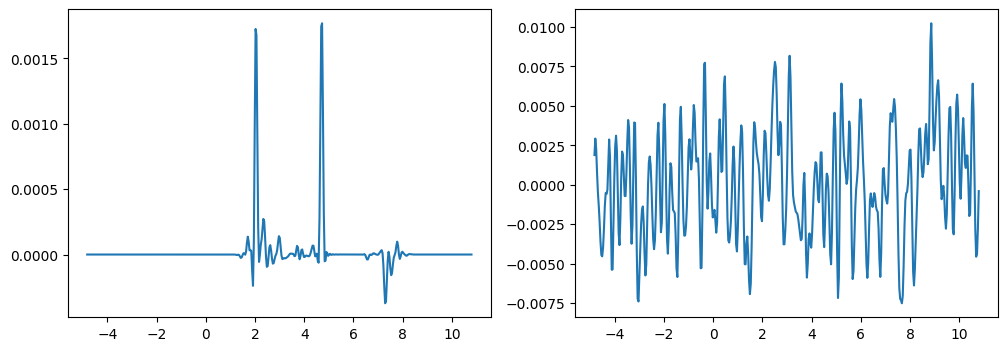

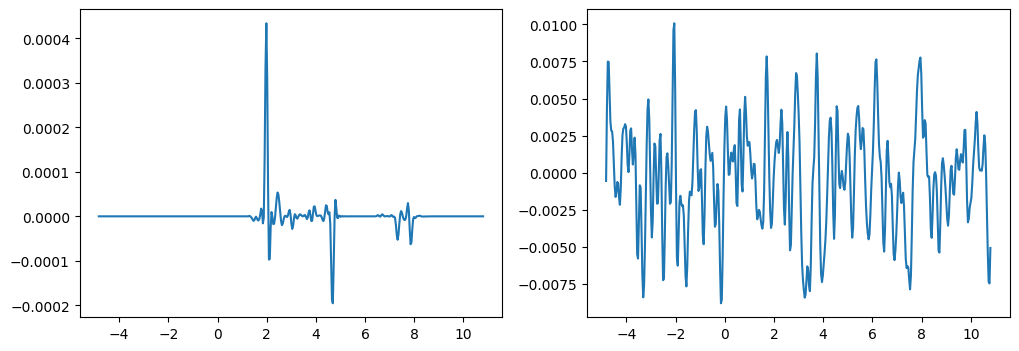

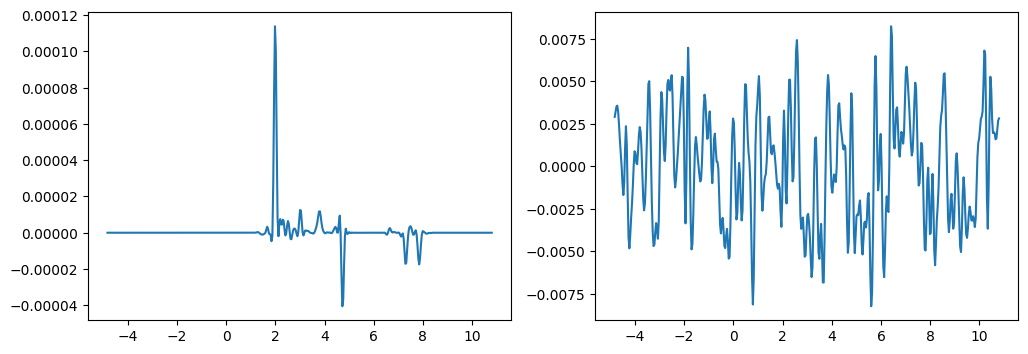

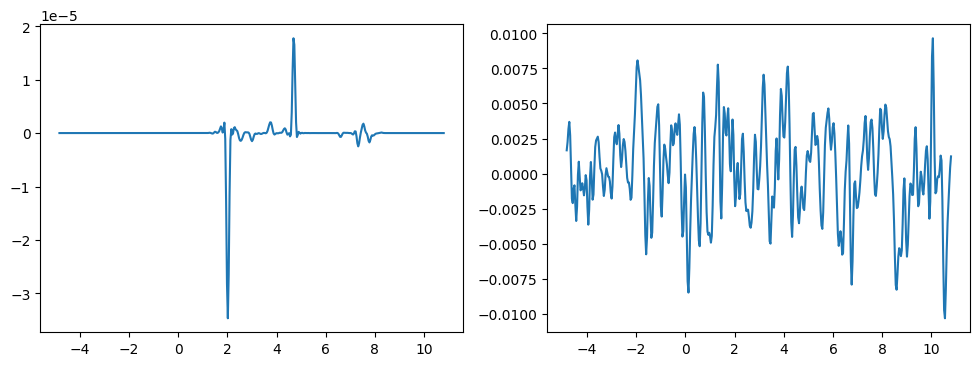

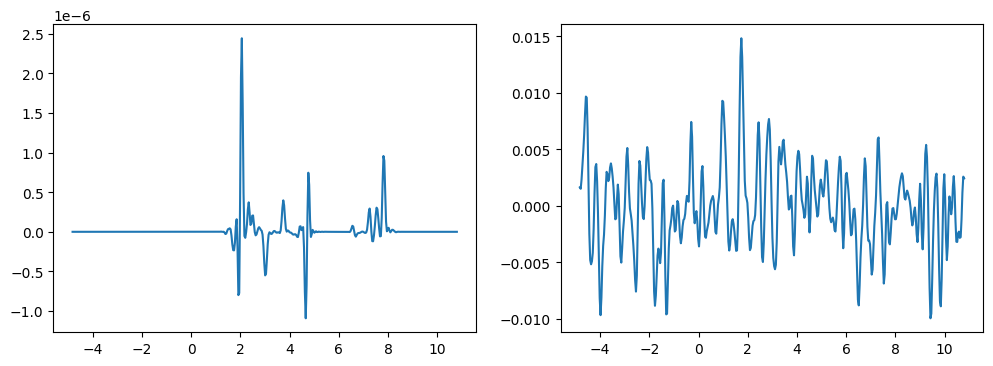

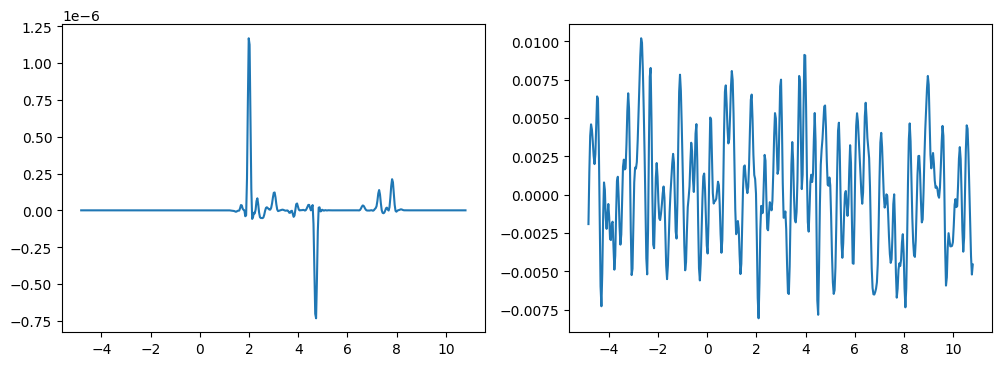

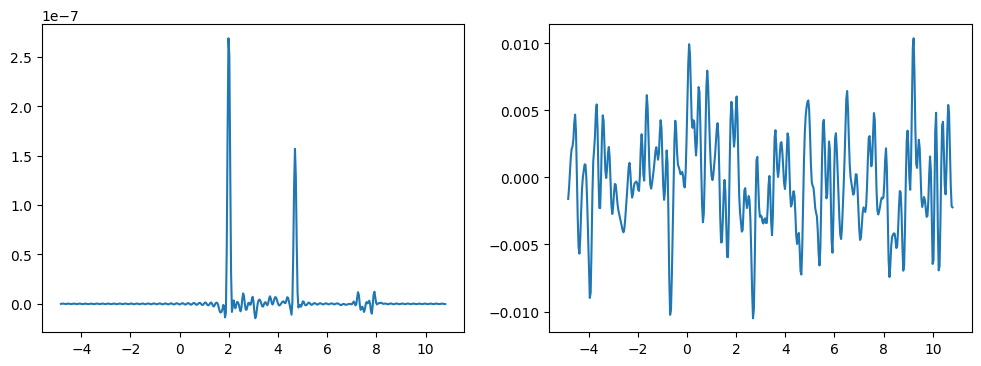

In [35]:
t_idx = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

for i in range(len(t_idx)):
    idx_time_1 = np.abs(t_spect - t_idx[i]).argmin()
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(np.flip(ppm_spect),np.real(spgram_gt_normABS[idx,:,idx_time_1]))
    ax[1].plot(np.flip(ppm_spect),np.real(spgram_corrupted_avgs_normABS[idx,:,idx_time_1]))


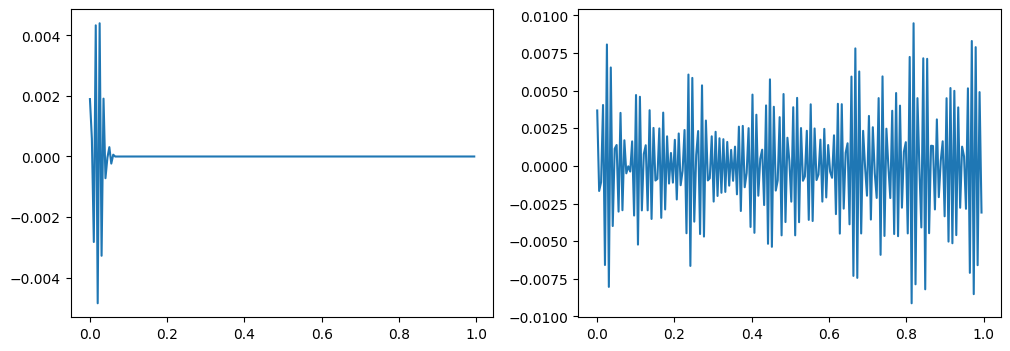

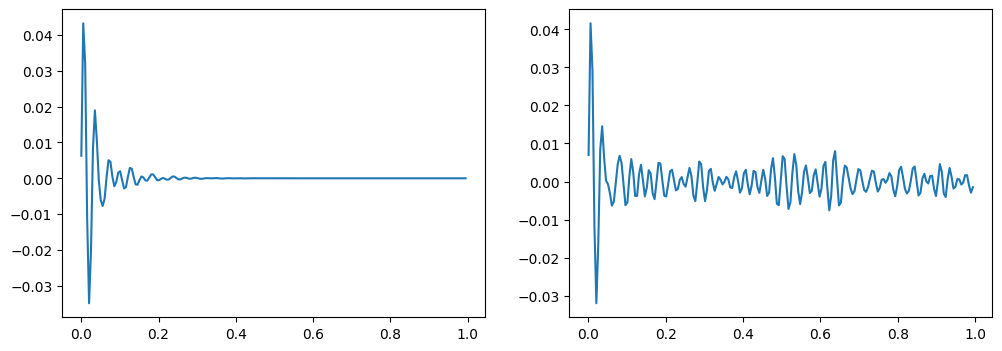

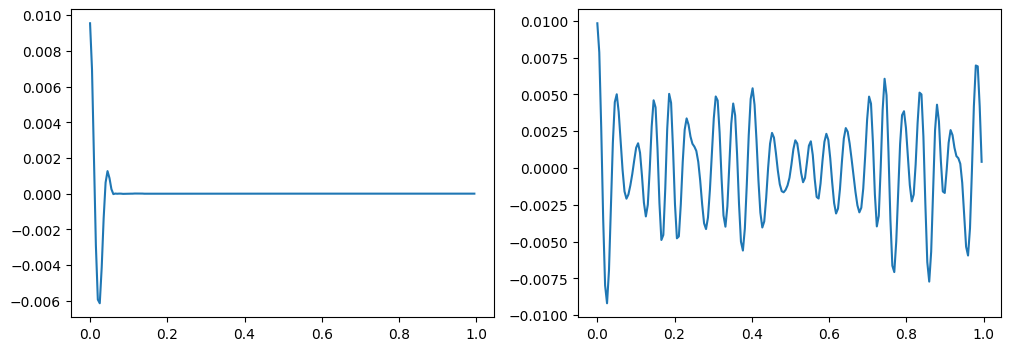

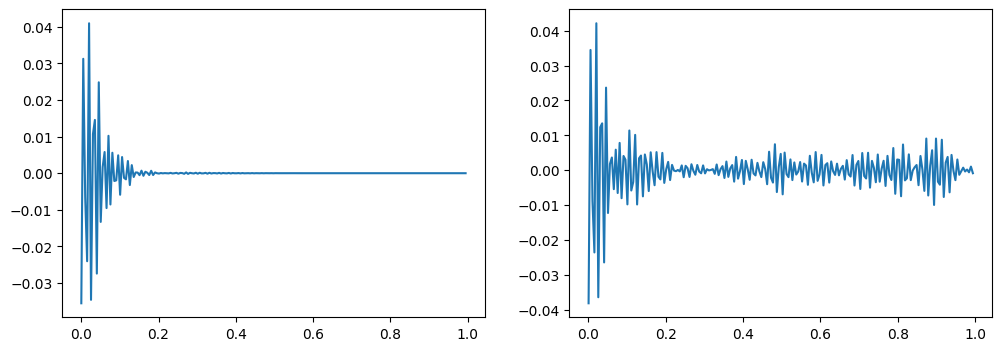

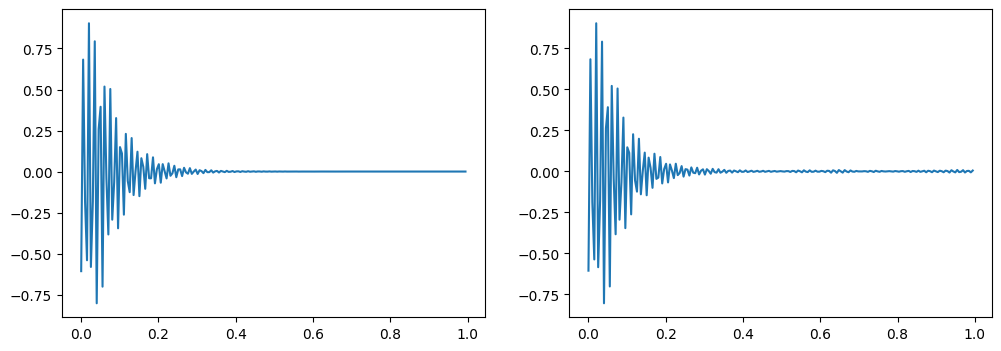

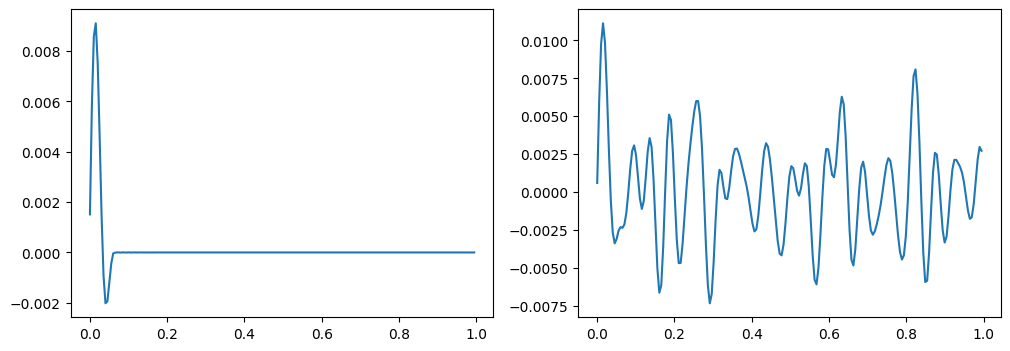

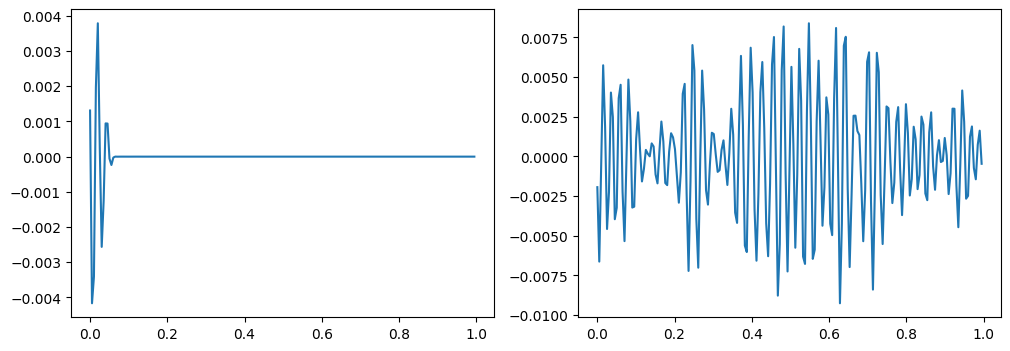

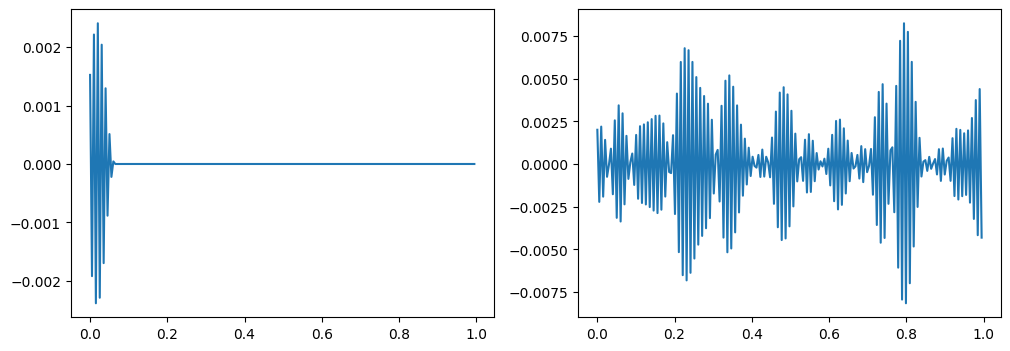

In [42]:
ppm_idx = [-4,-2,0,2,4,6,8,10]

for i in range(len(t_idx)):
    idx_ppm_1 = np.abs(ppm_spect - ppm_idx[i]).argmin()
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(t_spect,np.real(spgram_gt_normABS[idx,idx_ppm_1,:]))
    ax[1].plot(t_spect,np.real(spgram_corrupted_avgs_normABS[idx,idx_ppm_1,:]))


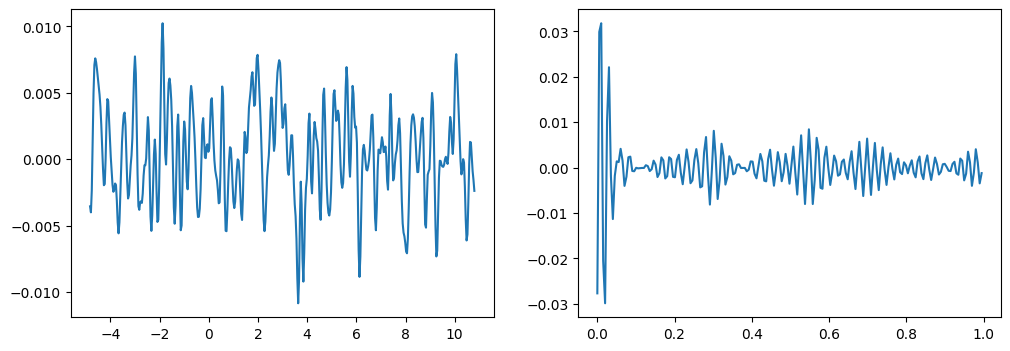

In [40]:
idx = 0
idx_time_1 = np.abs(t_spect - 0.65).argmin()
idx_time_2 = np.abs(t_spect - 1).argmin()
idx_freq = np.abs(np.flip(ppm_spect) - 4.2).argmin()
fig, ax = plt.subplots(1,2, figsize=(12,4))
#ax[0].plot(np.flip(ppm_spect),np.real(spgram_gt_normABS[idx,:,idx_time_1]))
ax[0].plot(np.flip(ppm_spect),np.real(spgram_corrupted_avgs_normABS[idx,:,idx_time_1]))
#ax[1].plot(t_spect,np.real(spgram_gt_normABS[idx,idx_freq,:]))
ax[1].plot(t_spect,np.real(spgram_corrupted_avgs_normABS[idx,idx_freq,:]))

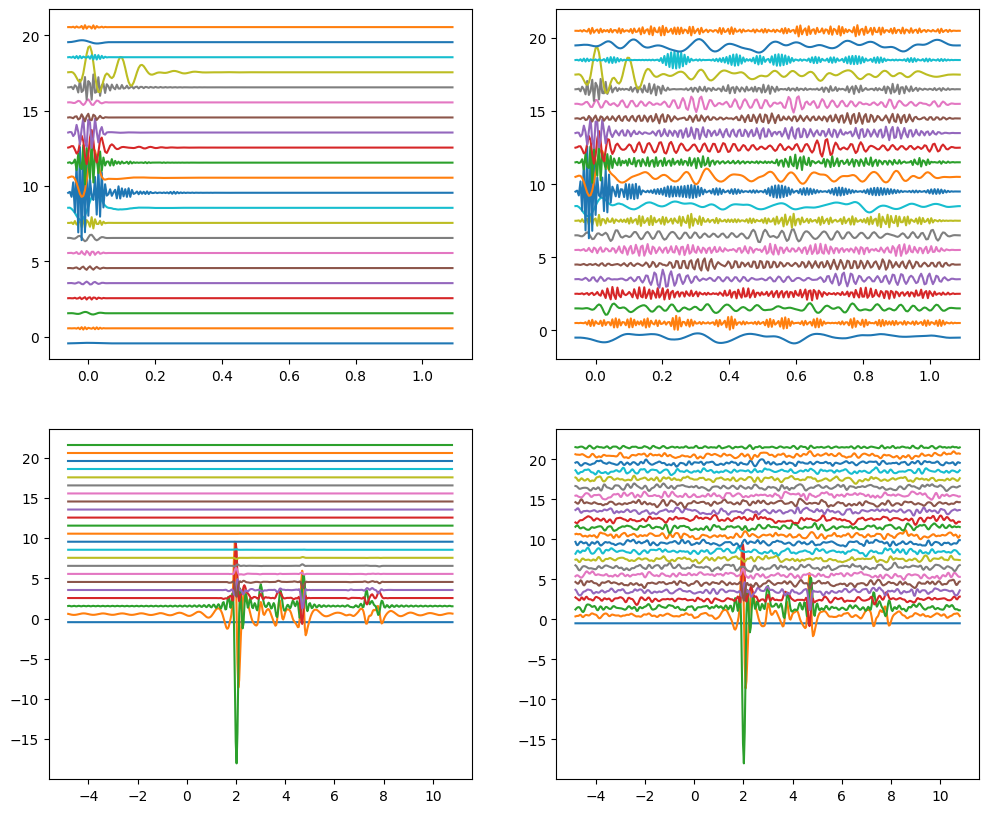

In [20]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
offset = 1
for i in range(int(np.round(spgram_gt_normABS.shape[1]/20))):
  ax[0,0].plot(t_spect,np.real(spgram_gt_normABS[idx,i*20,:])*20+offset*i)
  ax[0,1].plot(t_spect,np.real(spgram_corrupted_avgs_normABS[idx,i*20,:])*20+offset*i)
for i in range(int(np.round(spgram_gt_normABS.shape[2]/10))):
  ax[1,0].plot(np.flip(ppm_spect),np.real(spgram_gt_normABS[idx,:,i*10])*20+offset*i)
  ax[1,1].plot(np.flip(ppm_spect),np.real(spgram_corrupted_avgs_normABS[idx,:,i*10])*20+offset*i)

In [138]:
testing = np.empty((spgram_gt_normABS.shape[1],spgram_gt_normABS.shape[2]))
for i in range(spgram_gt_normABS.shape[1]):
    freqs_idx = np.random.uniform(0,10,size=10)
    amps_idx = np.random.uniform(0,0.1,size=10)
    phs_idx = np.random.uniform(0,90,size=10)
    m_t = amps_idx[0]*np.cos(2*np.pi*freqs_idx[0]*t_spect+(phs_idx[0]*np.pi/180))
    for j in range(freqs_idx.shape[0]-1):
        m_t = m_t + amps_idx[j]*np.cos(2*np.pi*freqs_idx[j+1]*t_spect+(phs_idx[j]*np.pi/180))
    Ac = np.max(np.real(spgram_corrupted_avgs_normABS[0,i,:]))
    fc = np.flip(freq_spect)[i]
    portadora = Ac*np.cos(2*np.pi*fc*t_spect)
    mod_ind = 1
    modulada = portadora*(1+mod_ind*m_t)
    testing[i,:] = modulada

In [131]:
print(testing.shape)

(446, 199)


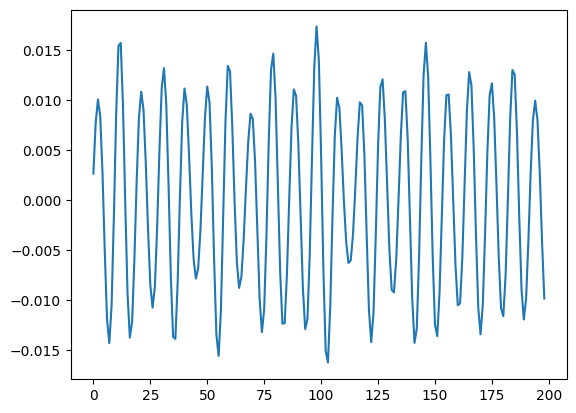

In [137]:
plt.plot(testing[50,:])

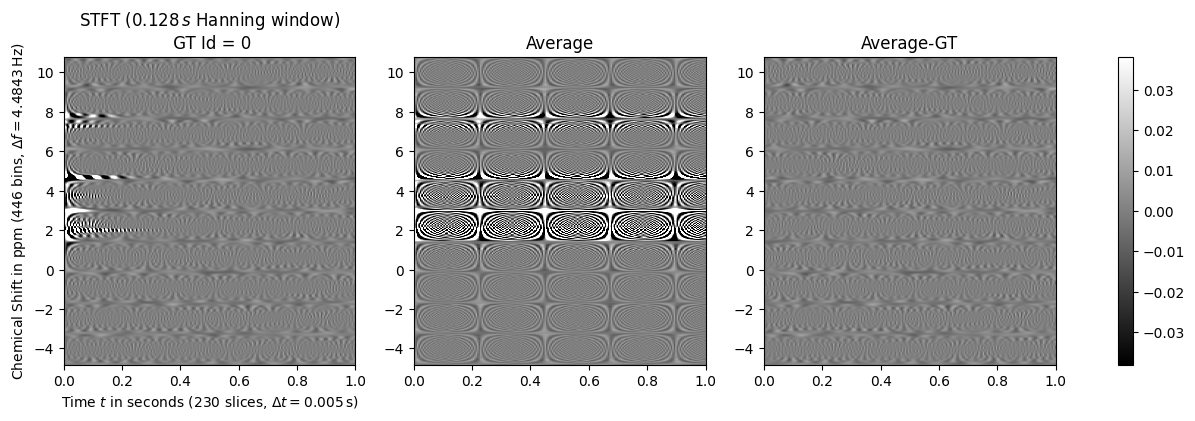

In [143]:
idx = 0

nrows=1
ncols=3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,4*nrows))

w = hann(256, sym=True)
mfft_ = 446
SFT = ShortTimeFFT(w, hop=10, fs=bandwidth, mfft=mfft_, scale_to='magnitude', fft_mode = 'centered')
t_lo, t_hi, f_lo, f_hi = SFT.extent(gt_fids.shape[1])

N_points = gt_fids[0,:,0].shape[0]
#t_lo, t_hi = SFT.extent(N_points)[:2]  # time range of plot
t_lo,t_hi=0,1

idx_plot = []
if nrows == 1:
  idx_plot.append(idx)
for i in range(nrows):
  idx_plot.append(random.randint(0, qntty))

ax.flat[0].set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Hanning window)"+ '\n GT Id = '+str(idx_plot[i]))
ax.flat[0].set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N_points)} slices, " + rf"$\Delta t = {SFT.delta_t:g}\,$s)",
               ylabel=f"Chemical Shift in ppm ({SFT.f_pts} bins, " + rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

vmin_ = np.mean(np.real(spgram_gt_normABS[idx_plot[0],:,:]))-2*np.std(np.real(spgram_gt_normABS[idx_plot[0],:,:]))
vmax_ = np.mean(np.real(spgram_gt_normABS[idx_plot[0],:,:]))+2*np.std(np.real(spgram_gt_normABS[idx_plot[0],:,:]))

#PLOT ONLY REAL PT
for i in range(nrows):
  im = ax.flat[i*ncols].imshow(np.real(spgram_corrupted_avgs_normABS[idx_plot[i],:,:]), origin='lower', aspect='auto',
                 extent=(t_lo,t_hi,ppm_spect[-1],ppm_spect[0]), cmap='gray' , vmin=vmin_, vmax = vmax_)
  im = ax.flat[i*ncols+1].imshow(testing, origin='lower', aspect='auto',
                 extent=(t_lo,t_hi,ppm_spect[-1],ppm_spect[0]), cmap='gray' , vmin=vmin_, vmax = vmax_)
  im = ax.flat[i*ncols+2].imshow(np.real(spgram_corrupted_avgs_normABS[idx_plot[i],:,:])-np.real(spgram_gt_normABS[idx_plot[i],:,:]), origin='lower', aspect='auto',
                 extent=(t_lo,t_hi,ppm_spect[-1],ppm_spect[0]), cmap='gray' , vmin=vmin_, vmax = vmax_)
  if i*ncols != 0:
    ax.flat[i*ncols].set_title(rf"GT Id = "+ str(idx_plot[i]))
  ax.flat[i*ncols+1].set_title('Average')
  ax.flat[i*ncols+2].set_title('Average-GT')
  if nrows == 1:
    fig.colorbar(im, ax=ax.ravel().tolist())
  else:
    fig.colorbar(im, ax=ax[i,:])

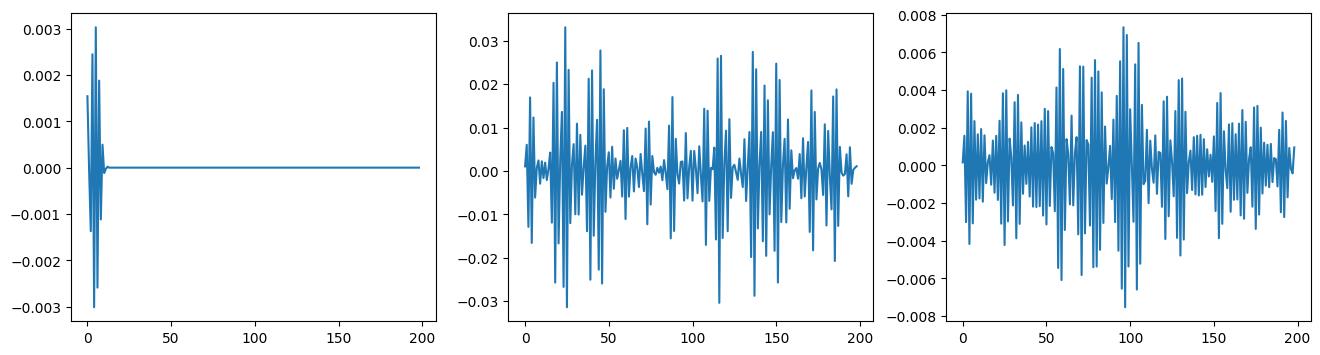

In [102]:
#m_t = np.random.normal(0,0.1,size=t_spect.shape)
freqs_idx = np.random.normal(0,10,size=10)
amps_idx = np.random.normal(0,0.1,size=10)
phs_idx = np.random.normal(0,90,size=10)
m_t = amps_idx[0]*np.cos(2*np.pi*freqs_idx[0]*t_spect+(phs_idx[0]*np.pi/180))
for i in range(freqs_idx.shape[0]-1):
    m_t = m_t + amps_idx[i]*np.cos(2*np.pi*freqs_idx[i+1]*t_spect+(phs_idx[i]*np.pi/180))
Ac = np.max(np.real(spgram_corrupted_avgs_normABS[0,20,:]))
fc = np.flip(freq_spect)[20]
portadora = Ac*np.cos(2*np.pi*fc*t_spect)
mod_ind = 10
modulada = portadora*(1+mod_ind*m_t)
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].plot(np.real(spgram_gt_normABS[0,20,:]))
ax[1].plot(modulada)
ax[2].plot(np.real(spgram_corrupted_avgs_normABS[0,20,:]))

In [31]:
def threshold_vector(vector, threshold):
    return np.where((vector > threshold) | (vector < -threshold), 0, 1)

thr_gt = threshold_vector(np.real(spgram_gt), 0.018)
thr_corrupted_avgs = threshold_vector(np.real(spgram_corrupted_avgs), 0.018)

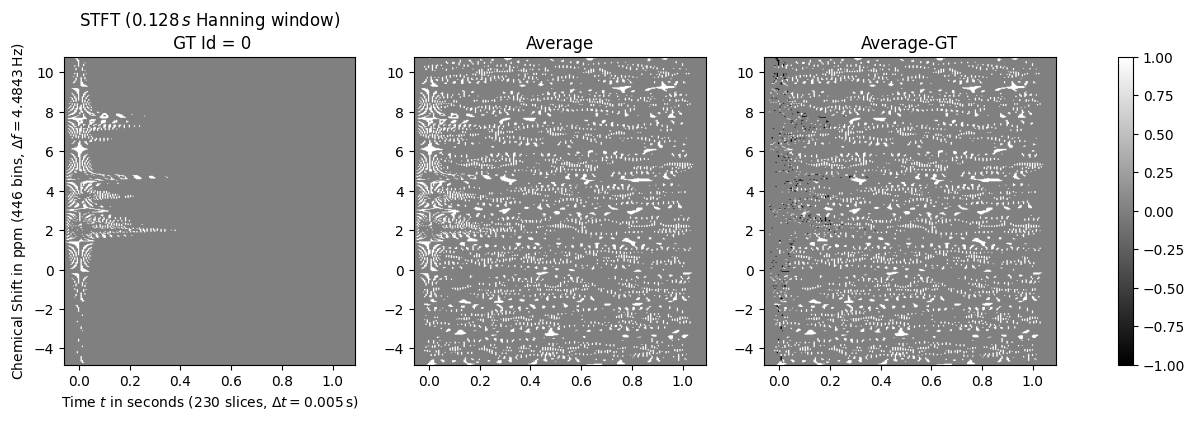

In [32]:
idx = 0

nrows=1
ncols=3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,4*nrows))

N_points = gt_fids[0,:,0].shape[0]
t_lo, t_hi = SFT.extent(N_points)[:2]  # time range of plot

idx_plot = []
if nrows == 1:
  idx_plot.append(idx)
for i in range(nrows):
  idx_plot.append(random.randint(0, qntty))

ax.flat[0].set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Hanning window)"+ '\n GT Id = '+str(idx_plot[i]))
ax.flat[0].set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N_points)} slices, " + rf"$\Delta t = {SFT.delta_t:g}\,$s)",
               ylabel=f"Chemical Shift in ppm ({SFT.f_pts} bins, " + rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

vmin_ = -1
vmax_ = 1
#PLOT ONLY REAL PT
for i in range(nrows):
  im = ax.flat[i*ncols].imshow(thr_gt[idx_plot[i],:,:], origin='lower', aspect='auto',
                 extent=(t_lo,t_hi,ppm_spect[-1],ppm_spect[0]), cmap='gray', vmin=vmin_, vmax = vmax_)
  im = ax.flat[i*ncols+1].imshow(thr_corrupted_avgs[idx_plot[i],:,:], origin='lower', aspect='auto',
                 extent=(t_lo,t_hi,ppm_spect[-1],ppm_spect[0]), cmap='gray' , vmin=vmin_, vmax = vmax_)
  im = ax.flat[i*ncols+2].imshow(thr_corrupted_avgs[idx_plot[i],:,:]-thr_gt[idx_plot[i],:,:], origin='lower', aspect='auto',
                 extent=(t_lo,t_hi,ppm_spect[-1],ppm_spect[0]), cmap='gray' , vmin=vmin_, vmax = vmax_)
  if i*ncols != 0:
    ax.flat[i*ncols].set_title(rf"GT Id = "+ str(idx_plot[i]))
  ax.flat[i*ncols+1].set_title('Average')
  ax.flat[i*ncols+2].set_title('Average-GT')
  if nrows == 1:
    fig.colorbar(im, ax=ax.ravel().tolist())
  else:
    fig.colorbar(im, ax=ax[i,:])